In [1]:
#export
import k1lib, math, numpy as np
from k1lib import cli
from typing import List, Tuple, ContextManager
from contextlib import contextmanager
try: import torch; from torch import nn; hasTorch = True
except: hasTorch = False
try: import matplotlib.animation
except: pass
__all__ = ["dummy"]

In [2]:
cli.init.patchNumpy()

In [3]:
#export
def dummy():
    """Does nothing. Only here so that you can read source code of this file and
see what’s up."""
    pass

In [4]:
#export
if hasTorch:
    @k1lib.patch(nn.Module)
    def importParams(self:nn.Module, params:List[nn.Parameter]):
        """Given a list of :class:`torch.nn.parameter.Parameter`/:class:`torch.Tensor`,
update the current :class:`torch.nn.Module`'s parameters with it'"""
        for oldParam, newParam in zip(self.parameters(), params):
            oldParam.data = newParam.data.clone()
    @k1lib.patch(nn.Module)
    def exportParams(self:nn.Module) -> List[torch.Tensor]:
        """Gets the list of :class:`torch.Tensor` data"""
        return [param.data.clone() for param in self.parameters()]
    class ParamsContext:
        def __init__(self, m:nn.Module): self.m = m
        def __enter__(self): self.params = self.m.exportParams(); return self.params
        def __exit__(self, *ignored): self.m.importParams(self.params)

In [5]:
#export
if hasTorch:
    @k1lib.patch(nn.Module)
    @contextmanager
    def paramsContext(self:nn.Module):
        """A nice context manager for :meth:`importParams` and :meth:`exportParams`.
Returns the old parameters on enter context. Example::

    m = nn.Linear(2, 3)
    with m.paramsContext() as oldParam:
        pass # go wild, train, mutate `m` however much you like
    # m automatically snaps back to the old param

Small reminder that this is not foolproof, as there are some :class:`~torch.nn.Module`
that stores extra information not accessible from the model itself, like
:class:`~torch.nn.BatchNorm2d`."""
        params = self.exportParams()
        try: yield
        finally: self.importParams(params)

In [6]:
m = nn.Linear(2, 3)
with m.paramsContext() as oldParam:
    m.weight.data[0, 0] = 1000; assert m.weight.data[0, 0] == 1000
assert m.weight.data[0, 0] < 999

In [7]:
#export
if hasTorch:
    @k1lib.patch(nn.Module)
    def getParamsVector(model:nn.Module) -> List[torch.Tensor]:
        """For each parameter, returns a normal distributed random tensor
with the same standard deviation as the original parameter"""
        answer = []
        for param in model.parameters():
            a = torch.randn(param.shape).to(param.device)
            b = param.std() if param.numel() > 1 else 1
            answer.append(a * b)
        return answer

In [8]:
#export
from k1lib.cli import apply, deref, op, item
if hasTorch:
    @k1lib.patch(nn.Module)
    @contextmanager
    def deviceContext(self:nn.Module, buffers:bool=True) -> ContextManager:
        """Preserves the device of whatever operation is inside this.
Example::

    import torch.nn as nn
    m = nn.Linear(3, 4)
    with m.deviceContext():
        m.cuda() # moves whole model to cuda
    # automatically moves model to cpu

This is capable of preserving buffers' devices too. But it might be unstable.
:class:`~torch.nn.parameter.Parameter` are often updated inline, and they keep
their old identity, which makes it easy to keep track of which device the parameters
are on. However, buffers are rarely updated inline, so their identities change all
the time. To deal with this, this does something like this::

    devices = [buf.device for buf in self.buffers()]
    yield # entering context manager
    for buffer, device in zip(self.buffers(), devices):
        buffer.data = buffer.data.to(device=device)

This means that while inside the context, if you add a buffer anywhere to the
network, buffer-device alignment will be shifted and wrong. So, register all
your buffers (aka Tensors attached to :class:`~torch.nn.Module`) outside this context
to avoid headaches, or set ``buffers`` option to False.

If you don't know what I'm talking about, don't worry and just leave as default.

:param buffers: whether to preserve device of buffers (regular Tensors attached
    to :class:`~torch.nn.Module`) or not."""
        pDevs = self.parameters() | apply(lambda t: (t, t.device)) | deref()
        if buffers: pbDevs = pbDevs = self.modules() |\
            apply(lambda m: (m, m | op().buffers(recurse=False) | op().device.all() | deref())) | deref(maxDepth=1)
        try: yield
        finally:
            for p, dev in pDevs: p.data = p.data.to(device=dev)
            if buffers:
                for m, bDevs in pbDevs:
                    for buf, dev in zip(m.buffers(recurse=False), bDevs):
                        buf.data = buf.data.to(device=dev)

In [9]:
l = k1lib.Learner.sample(); l.model.cpu()
with l.model.deviceContext(): l.model.cuda()
for p in l.model.parameters(): assert p.device.type == "cpu"

m = nn.Sequential(nn.Conv2d(3, 8, 3, 2), nn.BatchNorm2d(8)).cpu()
def isDev(dev): assert m[1].buffers() | op().device.type.all() | deref() == [dev] * 3
isDev("cpu")
with m.deviceContext(): m.cuda(); isDev("cuda")
isDev("cpu")

In [10]:
#export
if hasTorch:
    @k1lib.patch(nn.Module)
    @contextmanager
    def gradContext(self):
        """Preserves the requires_grad attribute.
Example::

    m = nn.Linear(2, 3)
    with m.gradContext():
        m.weight.requires_grad = False
    # returns True
    m.weight.requires_grad

It's worth mentioning that this does not work with buffers (Tensors attached to
:class:`torch.nn.Module`), as buffers are not meant to track gradients!"""
        grads = [(p, p.requires_grad) for p in self.parameters()]
        try: yield
        finally:
            for p, grad in grads: p.requires_grad_(grad)

In [11]:
m = nn.Linear(2, 3)
assert m.weight.requires_grad
with m.gradContext():
    m.weight.requires_grad = False
assert m.weight.requires_grad

In [12]:
#export
if hasTorch:
    @k1lib.patch(nn.Module)
    def __ror__(self, x):
        """Allows piping input to :class:`torch.nn.Module`, to match same style as
the module :mod:`k1lib.cli`. Example::

    # returns torch.Size([5, 3])
    torch.randn(5, 2) | nn.Linear(2, 3) | cli.shape()"""
        return self(x)

In [13]:
assert torch.randn(5, 2) | nn.Linear(2, 3) | cli.shape() == torch.Size([5, 3])

In [14]:
#export
if hasTorch:
    @k1lib.patch(nn.Module, name="nParams")
    @property
    def nParams(self):
        """Get the number of parameters of this module.
Example::

    # returns 9, because 6 (2*3) for weight, and 3 for bias
    nn.Linear(2, 3).nParams"""
        return sum([p.numel() for p in self.parameters()])

In [15]:
assert nn.Linear(2, 3).nParams == 9

In [16]:
#export
if hasTorch:
    @k1lib.patch(torch)
    @k1lib.patch(torch.Tensor)
    def crissCross(*others:Tuple[torch.Tensor]) -> torch.Tensor:
        """Concats multiple 1d tensors, sorts it, and get evenly-spaced values. Also
available as :meth:`torch.crissCross` and :meth:`~k1lib.cli.others.crissCross`.
Example::

    a = torch.tensor([2, 2, 3, 6])
    b = torch.tensor([4, 8, 10, 12, 18, 20, 30, 35])

    # returns tensor([2, 3, 6, 10, 18, 30])
    a.crissCross(b)

    # returns tensor([ 2,  4,  8, 10, 18, 20, 30, 35])
    a.crissCross(*([b]*10)) # 1 "a" and 10 "b"s

    # returns tensor([ 2,  2,  3,  6, 18])
    b.crissCross(*([a]*10)) # 1 "b" and 10 "a"s

Note how in the second case, the length is the same as tensor b, and the contents
are pretty close to b. In the third case, it's the opposite. Length is almost
the same as tensor a, and the contents are also pretty close to a."""
        return torch.cat([o.flatten() for o in others]).sort()[0][::len(others)]

In [17]:
a = torch.tensor([2, 2, 3, 6])
b = torch.tensor([4, 8, 10, 12, 18, 20, 30, 35])
assert (a.crissCross(b) == torch.tensor([2, 3, 6, 10, 18, 30])).all()
assert (a.crissCross(*([b]*10)) == torch.tensor([ 2,  4,  8, 10, 18, 20, 30, 35])).all()
assert (b.crissCross(*([a]*10)) == torch.tensor([ 2,  2,  3,  6, 18])).all()
assert (torch.crissCross(*([a] + [b]*10)) == a.crissCross(*([b]*10))).all()

In [18]:
#export
if hasTorch:
    @k1lib.patch(torch)
    def sameStorage(a, b):
        """Check whether 2 (:class:`np.ndarray` or :class:`torch.Tensor`)
has the same storage or not. Example::

    a = np.linspace(2, 3, 50)
    # returns True
    torch.sameStorage(a, a[:5])
    # returns True
    torch.sameStorage(a[:10], a[:5])
    returns false
    torch.sameStorage(a[:10], np.linspace(3, 4))

All examples above should work with PyTorch tensors as well."""
        if isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor):
            return a.data_ptr() == b.data_ptr()
        if isinstance(a, np.ndarray) and isinstance(b, np.ndarray):
            return a.base is b or b.base is a or a.base is b.base
        return a is b

In [19]:
a = np.linspace(2, 3, 50)
assert torch.sameStorage(a, a[:10])
assert torch.sameStorage(a[:4], a[:10])
assert not sameStorage(a[:10], np.linspace(3, 4))
a = torch.linspace(2, 3, 50)
assert torch.sameStorage(a, a[:10])
assert torch.sameStorage(a[:4], a[:10])

In [20]:
#export
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def histBounds(self:torch.Tensor, bins=100) -> torch.Tensor:
        r"""Flattens and sorts the tensor, then get value of tensor at regular
linspace intervals. Does not guarantee bounds' uniqueness. Example::

    # Tensor with lots of 2s and 5s
    a = torch.Tensor([2]*5 + [3]*3 + [4] + [5]*4)
    # returns torch.tensor([2., 3., 5.])
    a.histBounds(3).unique()

The example result essentially shows 3 bins: :math:`[2, 3)`, :math:`[3, 5)` and
:math:`[5, \infty)`. This might be useful in scaling pixels so that networks handle
it nicely. Rough idea taken from fastai.medical.imaging."""
        sortedTensor = self.flatten().sort()[0]
        ls = torch.linspace(0, 1, bins); ls[-1] = 1-1e-6
        bigLs = (ls * len(sortedTensor)).long()
        return sortedTensor[bigLs]

In [21]:
a = torch.Tensor([2]*5 + [3]*3 + [4] + [5]*4) # lots of 2s and 5s
assert torch.all(a.histBounds(3).unique() == torch.tensor([2., 3., 5.]))

In [22]:
#export
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def histScaled(self:torch.Tensor, bins=100, bounds=None) -> torch.Tensor:
        """Scale tensor's values so that the values are roughly spreaded out in range
:math:`[0, 1]` to ease neural networks' pain. Rough idea taken from
fastai.medical.imaging. Example::

    # normal-distributed values
    a = torch.randn(1000)
    # plot #1 shows a normal distribution
    plt.hist(a.numpy(), bins=30); plt.show()
    # plot #2 shows almost-uniform distribution
    plt.hist(a.histScaled().numpy()); plt.show()

Plot #1:

.. image:: images/histScaledNormal.png

Plot #2:

.. image:: images/histScaledUniform.png

:param bins: if ``bounds`` not specified, then will scale according to a hist
    with this many bins
:param bounds: if specified, then ``bins`` is ignored and will scale according to
    this. Expected this to be a sorted tensor going from ``min(self)`` to
    ``max(self)``."""
        if bounds is None: bounds = self.histBounds(bins).unique()
        else: bounds = bounds.unique()
        out = np.interp(self.numpy().flatten(), bounds, np.linspace(0, 1, len(bounds)))
        return torch.tensor(out).reshape(self.shape)

In [51]:
a = torch.randn(1000); plt.hist(a.numpy(), bins=30)
im1 = plt.gcf() | cli.toImg(); im1 | cli.toBytes() | cli.file("../docs/images/histScaledNormal.png")
a = torch.randn(1000); plt.hist(a.histScaled().numpy(), bins=30)
im2 = plt.gcf() | cli.toImg(); im1 | cli.toBytes() | cli.file("../docs/images/histScaledUniform.png")
k1lib.viz.Carousel([im1, im2])

In [23]:
a = torch.randn(1000); b = a.histScaled()
assert min(a) < -1; assert max(a) > 1; assert min(b) == 0.0; assert max(b) == 1.0

In [24]:
#export
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def positionalEncode(t:torch.Tensor, richFactor:float=2) -> torch.Tensor:
        r"""Position encode a tensor of shape :math:`(L, F)`, where :math:`L`
is the sequence length, :math:`F` is the encoded features. Will add the
encodings directly to the input tensor and return it.

This is a bit different from the standard implementations that ppl use.
This is exactly:

.. math:: p = \frac{i}{F\cdot richFactor}
.. math:: w = 1/10000^p
.. math:: pe = sin(w * L)

With ``i`` from range [0, F), and ``p`` the "progress". If ``richFactor`` is 1
(original algo), then ``p`` goes from 0% to 100% of the features. Example::

    import matplotlib.pyplot as plt, torch, k1lib
    plt.figure(dpi=150)
    plt.imshow(torch.zeros(100, 10).positionalEncode().T)

.. image:: images/positionalEncoding.png

:param richFactor: the bigger, the richer the features are. A lot of
    times, I observe that the features that are meant to cover huge scales
    are pretty empty and don't really contribute anything useful. So this
    is to bump up the usefulness of those features"""
        seqN, featsN = t.shape
        feats = torch.tensor(range(featsN)); w = (1/10000**(feats/featsN/richFactor))[None, :].expand(t.shape)
        times = torch.tensor(range(seqN))[:, None].expand(t.shape)
        t[:] = torch.sin(w * times); return t

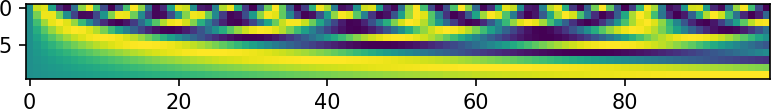

In [25]:
import matplotlib.pyplot as plt
plt.figure(dpi=150); plt.imshow(torch.zeros(100, 10).positionalEncode().T)
im = plt.gcf() | cli.toImg(); im | cli.toBytes() | cli.file("../docs/images/confusionMatrix.png"); im

In [26]:
#export
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def clearNan(self, value:float=0.0) -> torch.Tensor:
        """Sets all nan values to a specified value.
Example::

    a = torch.randn(3, 3) * float("nan")
    a.clearNan() # now full of zeros"""
        self[self != self] = value
        return self

In [27]:
assert (torch.randn(3, 3) * float("nan")).clearNan(1).sum() == 9

In [28]:
#export
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def hasNan(self) -> bool:
        """Returns whether this Tensor has any nan values at all."""
        return (self != self).sum() > 0

In [29]:
#export
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def stats(self) -> Tuple[float, float]:
        return self.mean(), self.std()

In [30]:
assert len(torch.randn(2, 3).stats()) == 2

In [31]:
#export
inf = float("inf")
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def hasInfs(self):
        """Whether this Tensor has negative or positive infinities."""
        return (self == inf).any() or (self == -inf).any()

In [32]:
assert (torch.tensor([2, 3])/0).hasInfs()
assert torch.tensor([2, inf]).hasInfs()
assert (torch.tensor([2, -3])/0).hasInfs()

In [33]:
#export
if hasTorch:
    @k1lib.patch(torch)
    def loglinspace(a, b, n=100, **kwargs):
        """Like :meth:`torch.linspace`, but spread the values out in log space,
    instead of linear space. Different from :meth:`torch.logspace`"""
        return math.e**torch.linspace(math.log(a), math.log(b), n, **kwargs)

In [34]:
#export
try:
    import graphviz
    @k1lib.patch(graphviz.Digraph, "__call__")
    @k1lib.patch(graphviz.Graph, "__call__")
    def _call(self, _from, *tos, **kwargs):
        """Convenience method to quickly construct graphs.
Example::

    g = k1lib.graph()
    g("a", "b", "c")
    g # displays arrows from "a" to "b" and "a" to "c"
"""
        for to in tos: self.edge(_from, to, **kwargs)
except: pass

In [35]:
#export
try:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D, art3d
    @k1lib.patch(Axes3D)
    def march(self, heatMap, level:float=0, facecolor=[0.45, 0.45, 0.75], edgecolor=None):
        """Use marching cubes to plot surface of a 3d heat map.
Example::

    plt.k3d(6).march(k1lib.perlin3d(), 0.17)

.. image:: images/march.png

A more tangible example::

    t = torch.zeros(100, 100, 100)
    t[20:30,20:30,20:30] = 1
    t[80:90,20:30,40:50] = 1
    plt.k3d().march(t.numpy())

The function name is "march" because how it works internally is by using
something called marching cubes.

:param heatMap: 3d numpy array
:param level: array value to form the surface on"""
        from skimage import measure
        try: verts, faces, normals, values = measure.marching_cubes(heatMap, level)
        except: verts, faces, normals, values = measure.marching_cubes_lewiner(heatMap, level)
        mesh = art3d.Poly3DCollection(verts[faces])
        if facecolor is not None: mesh.set_facecolor(facecolor)
        if edgecolor is not None: mesh.set_edgecolor(edgecolor)
        self.add_collection3d(mesh)
        self.set_xlim(0, heatMap.shape[0])
        self.set_ylim(0, heatMap.shape[1])
        self.set_zlim(0, heatMap.shape[2]); return self
    @k1lib.patch(Axes3D)
    def aspect(self):
        """Use the same aspect ratio for all axes."""
        self.set_box_aspect([ub - lb for lb, ub in (getattr(self, f'get_{a}lim')() for a in 'xyz')])
    @k1lib.patch(plt)
    def k3d(size=8, labels=True, *args, **kwargs):
        """Convenience function to get an :class:`~mpl_toolkits.mplot3d.axes3d.Axes3D`.

:param labels: whether to include xyz labels or not
:param size: figure size"""
        if isinstance(size, (int, float)): size = (size, size)
        fig = plt.figure(figsize=size, constrained_layout=True, *args, **kwargs)
        ax = fig.add_subplot(projection="3d")
        if labels:
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
        return ax
    @k1lib.patch(plt)
    def animate(azimSpeed=3, azimStart=0, elevSpeed=0.9, elevStart=0, frames=20, close=True):
        """Animates the existing 3d axes.
Example::

    plt.k3d().scatter(*np.random.randn(3, 10))
    plt.animate()

:param frames: how many frames to render? Frame rate is 30 fps
:param close: whether to close the figure (to prevent the animation and
    static plot showing at the same time) or not"""
        fig = plt.gcf()
        def f(frame):
            for ax in fig.axes:
                ax.view_init(elevStart+frame*elevSpeed, azimStart+frame*azimSpeed)
        if close: plt.close()
        return k1lib.viz.FAnim(fig, f, frames)
    @k1lib.patch(plt)
    def getFig():
        """Grab figure of the current plot.
Example::

    plt.plot() | plt.getFig() | toImg()

Internally, this just calls ``plt.gcf()`` and that's it, pretty simple.
But I usually plot things as a part of the cli pipeline, and it's very
annoying that I can't quite chain ``plt.gcf()`` operation, so I created
this"""
        def inner(_): return plt.gcf()
        return cli.aS(inner)
except: pass

In [36]:
plt.k3d().scatter(*np.random.randn(3, 10))
plt.animate()

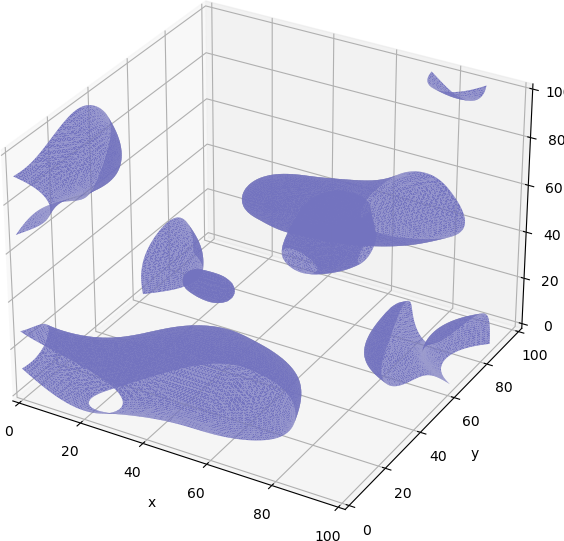

In [37]:
plt.k3d(6).march(k1lib.perlin3d(), 0.17)
im = plt.gcf() | cli.toImg(); im | cli.toBytes() | cli.file("../docs/images/march.png"); im

In [38]:
#export
try:
    @k1lib.patch(Axes3D)
    def plane(self, origin, v1, v2=None, s1:float=1, s2:float=1, **kwargs):
        """Plots a 3d plane.

:param origin: origin vector, shape (3,)
:param v1: 1st vector, shape (3,)
:param v2: optional 2nd vector, shape(3,). If specified, plots a plane created
    by 2 vectors. If not, plots a plane perpendicular to the 1st vector
:param s1: optional, how much to scale 1st vector by
:param s2: optional, how much to scale 2nd vector by
:param kwargs: keyword arguments passed to :meth:`~mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface`"""
        v1 = (v1 if isinstance(v1, torch.Tensor) else torch.tensor(v1)).float()
        if v2 is None:
            v = v1
            v1 = torch.tensor([1.0, 1, -(v[0]+v[1])/v[2]])
            v2 = torch.cross(v, v1)
        v2 = (v2 if isinstance(v2, torch.Tensor) else torch.tensor(v2)).float()
        origin = (origin if isinstance(origin, torch.Tensor) else torch.tensor(origin)).float()
        x = torch.linspace(-1, 1, 50)[:,None]
        v1 = (v1[None,:]*x*s1)[:,None]
        v2 = (v2[None,:]*x*s2)[None,:]
        origin = origin[None,None,:]
        plane = (origin + v1 + v2).permute(2, 0, 1)
        self.plot_surface(*plane.numpy(), **kwargs)
except: pass

In [39]:
#export
try:
    @k1lib.patch(Axes3D)
    def point(self, v, **kwargs):
        """Plots a 3d point.

:param v: point location, shape (3,)
:param kwargs: keyword argument passed to :meth:`~mpl_toolkits.mplot3d.axes3d.Axes3D.scatter`"""
        v = (v if hasTorch and isinstance(v, torch.Tensor) else torch.tensor(v)).float()
        self.scatter(*v, **kwargs)
    @k1lib.patch(Axes3D)
    def line(self, v1, v2, **kwargs):
        """Plots a 3d line.

:param v1: 1st point location, shape (3,)
:param v2: 2nd point location, shape (3,)
:param kwargs: keyword argument passed to :meth:`~mpl_toolkits.mplot3d.axes3d.Axes3D.plot`"""
        self.plot(*torch.tensor([list(v1), list(v2)]).float().T, **kwargs)
except: pass

In [40]:
#export
try:
    @k1lib.patch(Axes3D)
    def surface(self, z, **kwargs):
        """Plots 2d surface in 3d. Pretty much exactly the same as
:meth:`~mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface`, but fields x and y
are filled in automatically. Example::

    x, y = np.meshgrid(np.linspace(-2, 2), np.linspace(-2, 2))
    plt.k3d(6).surface(x**3 + y**3)

.. image:: images/surface.png

:param z: 2d numpy array for the heights
:param kwargs: keyword arguments passed to ``plot_surface``"""
        if hasTorch and isinstance(z, torch.Tensor): z = z.numpy()
        x, y = z.shape
        x, y = np.meshgrid(np.array(range(y)), np.array(range(x)))
        return self.plot_surface(x, y, z, **kwargs)
except: pass

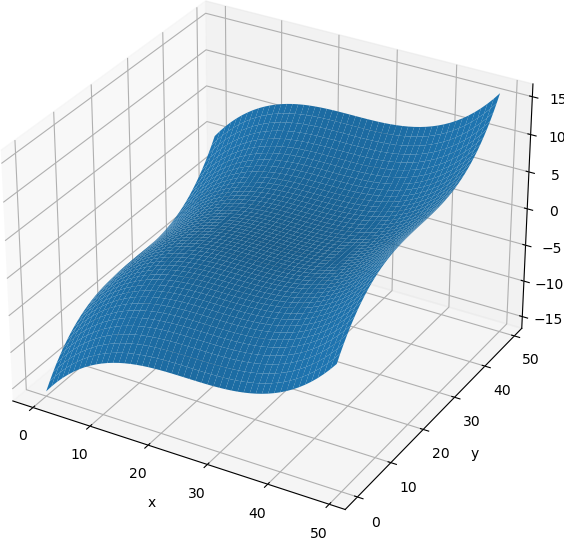

In [41]:
x, y = np.meshgrid(np.linspace(-2, 2), np.linspace(-2, 2))
plt.k3d(6).surface(x**3 + y**3); im = plt.gcf() | cli.toImg()
im | cli.toBytes() | cli.file("../docs/images/surface.png"); im

In [42]:
#export
try:
    import pandas as pd
    @k1lib.patch(pd.DataFrame)
    def table(self):
        """Converts a :class:`pandas.core.frame.DataFrame` to a normal table made
from lists (with column headers), so that it can be more easily manipulated
with cli tools. Example::

    pd.read_csv("abc.csv").table()"""
        yield self.columns.to_list()
        yield from self.values
except: pass

In [43]:
#export
try:
    import forbiddenfruit
    def splitCamel(s):
        """Splits a string up based on camel case.
Example::

    # returns ['IHave', 'No', 'Idea', 'What', 'To', 'Put', 'Here']
    "IHaveNoIdeaWhatToPutHere".splitCamel()"""
        words = [[s[0]]]
        for c in s[1:]:
            if words[-1][-1].islower() and c.isupper():
                words.append(list(c))
            else: words[-1].append(c)
        return [''.join(word) for word in words]
    forbiddenfruit.curse(str, "splitCamel", splitCamel)
except: pass

In [44]:
assert "IHaveNoIdeaWhatToPutHere".splitCamel() == ['IHave', 'No', 'Idea', 'What', 'To', 'Put', 'Here']

In [2]:
!../export.py _monkey

Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.3.2.2
Uninstalling k1lib-1.3.2.2:
  Successfully uninstalled k1lib-1.3.2.2
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.